In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [3]:
from eden.util.NeedlemanWunsh import edit_distance

def select_best_match(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = 0
        max_motif = None
        for cluster_id in motives:
            consensus_seq = motives[cluster_id]['consensus_seq']
            score = edit_distance(orig_motif, consensus_seq)
            score = 2 * float(score) / (len(orig_motif)+len(consensus_seq))
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
        yield max_score, max_cluster_id

In [4]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [5]:
% matplotlib inline
import pylab as plt 
import numpy as np

def make_experiment(complexity=3,
                    motif_length=10,
                    n_motives=2,
                    sequence_length=30,
                    n_sequences=1001,
                    perturbation_prob=0.3,
                    min_score=4,
                    min_freq=0.5,
                    min_cluster_size=10,
                    n_clusters=10,
                    min_subarray_size=5,
                    max_subarray_size=15,
                    similarity_threshold=.5,
                    freq_threshold=0.1,
                    regex_th=.5,
                    sample_size=200,
                    std_threshold=20,
                   p_value=0.05):
    pos_seqs, targets, orig_motives = make_artificial_dataset('ACGU',
                                                             motif_length,
                                                             sequence_length,
                                                             n_sequences,
                                                             n_motives,
                                                             perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(pos_seqs)
    train_pos_seqs = pos_seqs[:pos_size/2]
    test_pos_seqs = pos_seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]
    test_neg_seqs = neg_seqs[neg_size/2:]

    from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
    smod=SMoD(complexity=complexity,
              n_clusters=n_clusters,
              min_subarray_size=min_subarray_size,
              max_subarray_size=max_subarray_size,
              pos_block_size=block_size,
              neg_block_size=block_size)
    
    smod = smod.fit(train_pos_seqs, train_neg_seqs)
    try:
        motives = smod.select_motives(seqs=pos_seqs,
                                        p_value=0.05,
                                        similarity_th=similarity_threshold,
                                        min_score=min_score,
                                        min_freq=min_freq,
                                        min_cluster_size=5,
                                        regex_th=regex_th,
                                        sample_size=sample_size,
                                        freq_th=freq_threshold,
                                        std_th=std_threshold)
        avg_score = np.mean([s for s,id in select_best_match(motives, orig_motives)])
    except Exception as e:
        avg_score=0
    return avg_score

def plot_results(data, title='Experiment', xlabel='param', ylabel='values'):
    data_x =  np.array([param for param, val, std in data])
    data_y =  np.array([val for param, val, std in data])
    data_d =  np.array([val for param, val, std in data])
    
    plt.figure(figsize=(16,3))
    plt.plot(data_x, data_y, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y - data_d, data_y + data_d, alpha=0.1, color="b")
    plt.plot(data_x, data_y, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    plt.ylim([0, 1])
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.show()

# Common settings

In [6]:
n_rep=10

# Exp noise

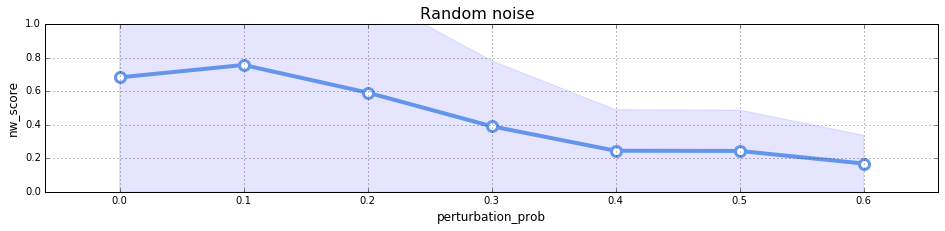

CPU times: user 47 s, sys: 15.5 s, total: 1min 2s
Wall time: 12min 39s


In [6]:
%%time
def make_results(n_rep=n_rep):
    for param in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=7,
                                        n_motives=3,
                                        sequence_length=80,
                                        n_sequences=500,
                                        perturbation_prob=param,
                                        min_score=4,
                                        min_freq=0.5,
                                        min_cluster_size=5,
                                        n_clusters=20,
                                        min_subarray_size=4,
                                        max_subarray_size=10,
                                        similarity_threshold=.5,
                                        freq_threshold=None,
                                        regex_th=.3,
                                        sample_size=100,
                                        std_threshold=None,
                                        p_value=0.05)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std


data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='nw_score')

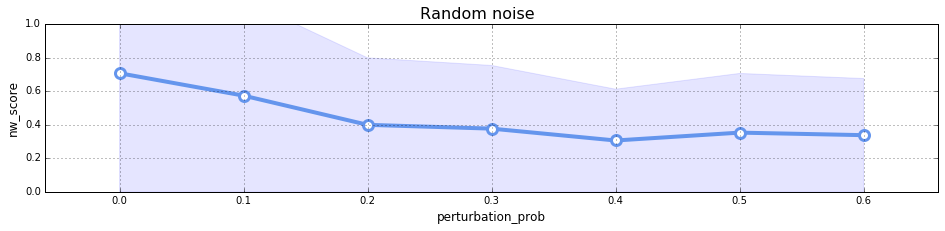

CPU times: user 1min 28s, sys: 23.6 s, total: 1min 51s
Wall time: 33min 23s


In [7]:
%%time
def make_results(n_rep=n_rep):
    for param in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=7,
                                        n_motives=3,
                                        sequence_length=80,
                                        n_sequences=1000,
                                        perturbation_prob=param,
                                        min_score=4,
                                        min_freq=0.5,
                                        min_cluster_size=5,
                                        n_clusters=20,
                                        min_subarray_size=4,
                                        max_subarray_size=10,
                                        similarity_threshold=.5,
                                        freq_threshold=None,
                                        regex_th=.3,
                                        sample_size=200,
                                        std_threshold=None,
                                        p_value=0.05)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std


data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='nw_score')

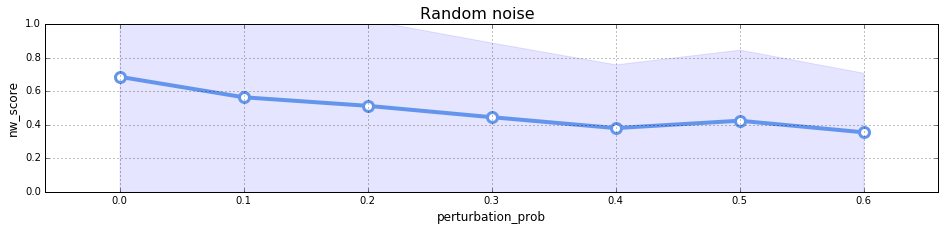

CPU times: user 2min 8s, sys: 34.5 s, total: 2min 43s
Wall time: 54min 9s


In [8]:
%%time
def make_results(n_rep=n_rep):
    for param in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=7,
                                        n_motives=3,
                                        sequence_length=80,
                                        n_sequences=3000,
                                        perturbation_prob=param,
                                        min_score=4,
                                        min_freq=0.5,
                                        min_cluster_size=5,
                                        n_clusters=20,
                                        min_subarray_size=4,
                                        max_subarray_size=10,
                                        similarity_threshold=.5,
                                        freq_threshold=None,
                                        regex_th=.3,
                                        sample_size=200,
                                        std_threshold=None,
                                        p_value=0.05)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std


data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='nw_score')

# Exp num sequences

Quality filter is too strict. Reverting.
Quality filter is too strict. Reverting.
Quality filter is too strict. Reverting.
Quality filter is too strict. Reverting.


/Users/costa/Desktop/BTSync/Projects/EDeN/EDeN/eden/sequence_motif_decomposer.py:47: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(x - a) / b))


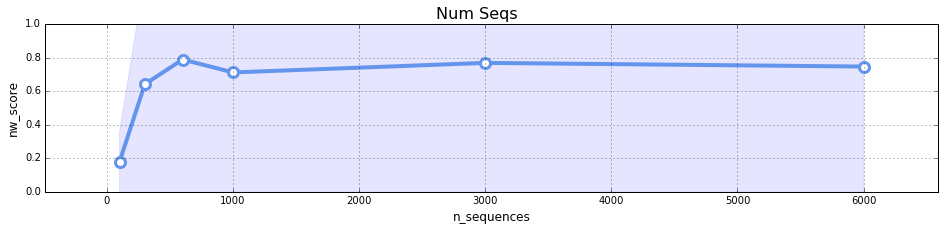

CPU times: user 1min 10s, sys: 22.2 s, total: 1min 32s
Wall time: 17min 44s


In [7]:
%%time
def make_results(n_rep=n_rep):
    for param in [100,300,600,1000,3000,6000]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=7,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=param,
                                        perturbation_prob=.2,
                                        min_score=4,
                                        min_freq=0.5,
                                        min_cluster_size=5,
                                        n_clusters=20,
                                        min_subarray_size=4,
                                        max_subarray_size=10,
                                        similarity_threshold=.5,
                                        freq_threshold=None,
                                        regex_th=.3,
                                        sample_size=200,
                                        std_threshold=None,
                                        p_value=0.05)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std


data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Num Seqs', xlabel='n_sequences', ylabel='nw_score')

# Exp num clusters

Quality filter is too strict. Reverting.
Quality filter is too strict. Reverting.


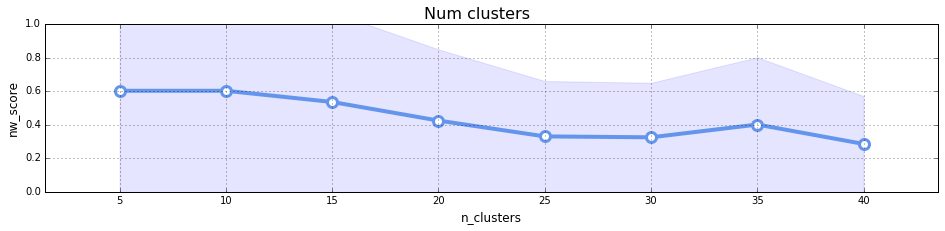

CPU times: user 42.6 s, sys: 19.6 s, total: 1min 2s
Wall time: 10min 59s


In [6]:
%%time
def make_results(n_rep=n_rep):
    for param in [5,10,15,20,25,30,35,40]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=7,
                                        n_motives=3,
                                        sequence_length=80,
                                        n_sequences=500,
                                        perturbation_prob=0.2,
                                        min_score=4,
                                        min_freq=0.5,
                                        min_cluster_size=5,
                                        n_clusters=param,
                                        min_subarray_size=4,
                                        max_subarray_size=10,
                                        similarity_threshold=.5,
                                        freq_threshold=None,
                                        regex_th=.3,
                                        sample_size=100,
                                        std_threshold=None,
                                        p_value=0.05)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std
        

data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Num clusters', xlabel='n_clusters', ylabel='nw_score')

# Exp motif size

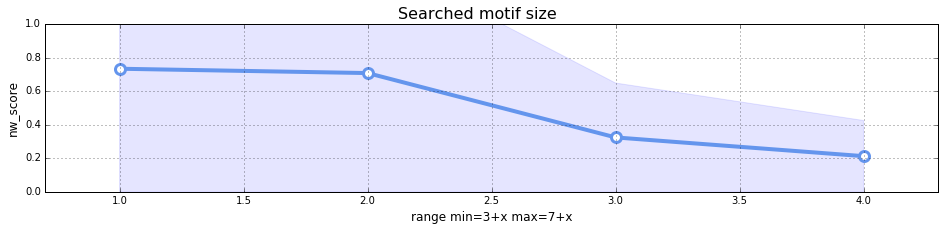

CPU times: user 29.7 s, sys: 12 s, total: 41.8 s
Wall time: 11min 54s


In [9]:
%%time
def make_results(n_rep=n_rep):
    for param in [1,2,3,4]:
        avg_scores=[]
        for rep in range(n_rep):
            avg_score = make_experiment(complexity=5,
                                        motif_length=7,
                                        n_motives=3,
                                        sequence_length=50,
                                        n_sequences=1000,
                                        perturbation_prob=.2,
                                        min_score=5,
                                        min_freq=0.65,
                                        min_cluster_size=10,
                                        n_clusters=10,
                                        min_subarray_size=3+param,
                                        max_subarray_size=7+param,
                                        similarity_threshold=.5,
                                        freq_threshold=None,
                                         regex_th=.3,
                                        sample_size=200,
                                        std_threshold=None,
                                        p_value=0.05)
            avg_scores.append(avg_score)
        val = np.mean(avg_scores)
        std = np.std(avg_scores)
        yield param, val, std
        

data = [(param, val, std) for param, val, std in make_results()]
plot_results(data, title='Searched motif size', xlabel='range min=3+x max=7+x', ylabel='nw_score')

---